# **First model for the project**

# **Load lib**

In [1]:
!pip install pyvi > /dev/null 2>&1
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input,MaxPooling1D, GlobalMaxPooling1D, LayerNormalization, Conv1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

# **Load data**

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/hungitnoi/model-for-project/refs/heads/master/df_voz.csv')
label_mapping = {
    -1: "tiêu cực",
    0: "trung lập",
    1: "tích cực"
}
df['label'] = df['label'].map(label_mapping)



# **Data preparation and preprocessing for tranning**

## data separation as Input_label and input_data



### Input_label: target variable

In [9]:
Input_label = df['label']
Input_label

,label
0,tiêu cực
1,tích cực
2,tiêu cực
3,tiêu cực
4,tích cực
...,...
2855,trung lập
2856,trung lập
2857,trung lập
2858,trung lập


### input_data: data features

In [4]:
input_data = df['message']
input_data

,message
0,Report mọi post/ thread vi phạm nội quy box f1...
1,"Ưu tiên report các bình luận có chứa ngôn từ ""..."
2,"Thread chỉ nhận report, nghiêm cấm mọi hành vi..."
3,"Các vấn đề thắc mắc, khiếu nại liên quan... hã..."
4,Thank you all
...,...
2855,giấy kết hôn - chụp hình 2
2856,giấy khai sinh - chụp hình
2857,"Tình hình là mình đang ở chung cư nhà nước, đa..."
2858,Đi ra công an thì họ bảo khi nào làm lại hợp đ...


###Processing data

In [10]:
label_dict = {'tiêu cực':0, 'trung lập':1, 'tích cực':2}

input_pre=[]
label_with_accent=[]
for idx,dt in enumerate(input_data):
  input_text_pre=list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre=" ".join(input_text_pre)
  input_text_pre_no_accent=str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  input_text_pre_accent=ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent=ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(Input_label[idx])
  label_with_accent.append(Input_label[idx])

<function matplotlib.pyplot.show(close=None, block=None)>

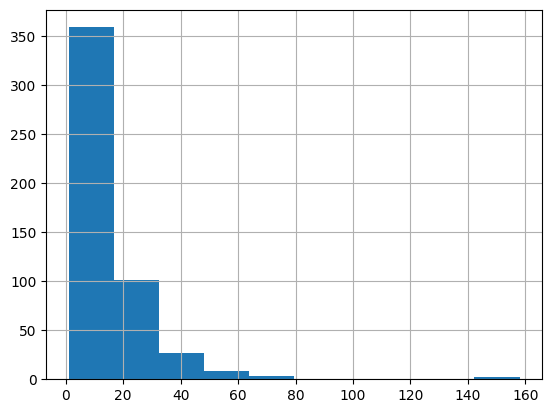

In [69]:
seq_len= [len(i.split()) for i in input_pre[0:500]]
pd.Series(seq_len).hist(bins=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

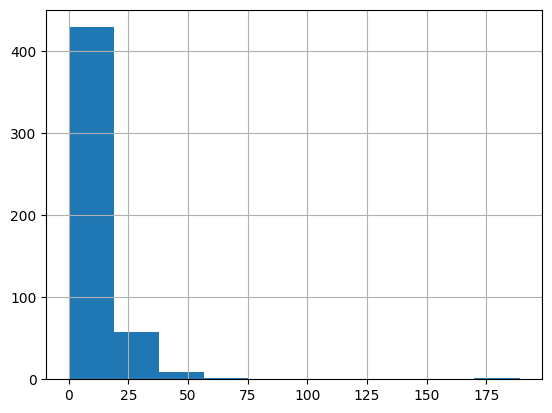

In [21]:
seq_len= [len(i.split()) for i in input_pre[500:1000]]
pd.Series(seq_len).hist(bins=10)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

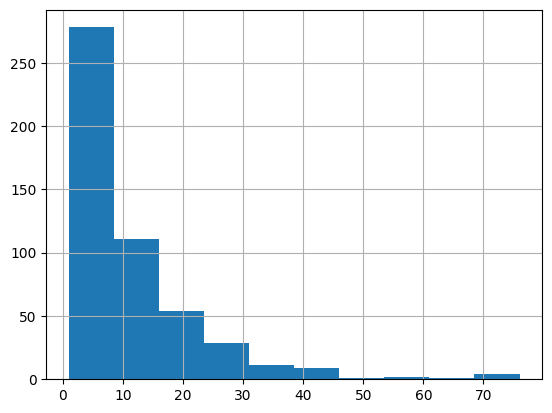

In [22]:
seq_len= [len(i.split()) for i in input_pre[1000:1500]]
pd.Series(seq_len).hist(bins=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

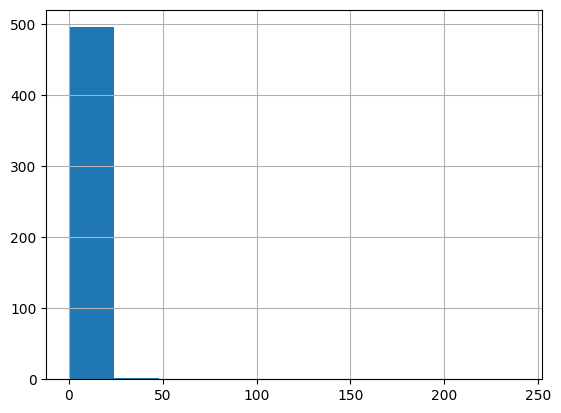

In [23]:
seq_len= [len(i.split()) for i in input_pre[1500:2000]]
pd.Series(seq_len).hist(bins=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

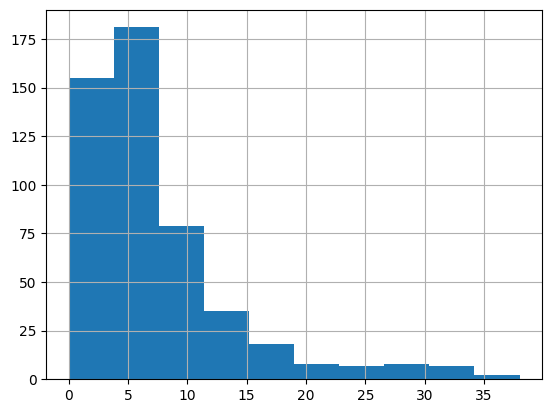

In [24]:
seq_len= [len(i.split()) for i in input_pre[2000:2500]]
pd.Series(seq_len).hist(bins=10)
plt.show

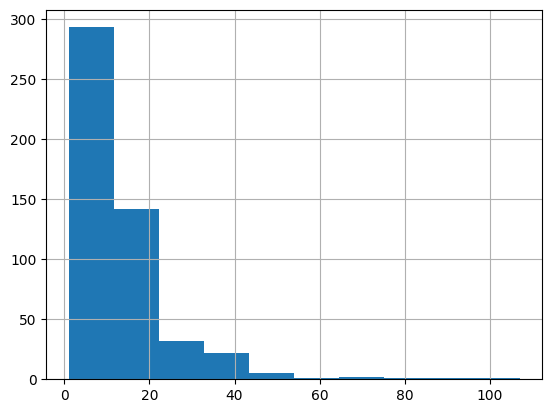

In [26]:
seq_len= [len(i.split()) for i in input_pre[2500:3000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

In [27]:
#As we see over 6 chart, the mean of word in 1 sentenc is about 335 words, so we use it!
lable_idx=[label_dict[i] for i in label_with_accent]
lable_tf=tf.keras.utils.to_categorical(lable_idx,num_classes=3)

tokenizer_data=Tokenizer(oov_token='<OOV>', filters='',split= ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre) #Change text_to_word_sequence to text_to_sequences
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=335)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print("input data.shape",vec_data.shape)
data_vocab_size=len(tokenizer_data.word_index)+1
print("data_vocab_size",data_vocab_size)

x_train,x_val,y_train,y_val=train_test_split(vec_data,lable_tf,test_size=0.2,random_state=42)
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.1,random_state=42)
print("Training sample",len(x_train))
print("Validation sample",len(x_val))
print("Test sample",len(x_test))

input data.shape (5720, 335)
data_vocab_size 5209
Training sample 4118
Validation sample 1144
Test sample 458


##Create Model from Scracth

In [47]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 335
    initializer = tf.keras.initializers.GlorotNormal()
    regularizer = tf.keras.regularizers.l2(0.01)  # Add L2 regularization

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim,
                        input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizer)(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizer)(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu', kernel_regularizer=regularizer)(combine_feature)
    classifier = Dropout(0.3)(classifier)  # Adjusted Dropout rate
    classifier = Dense(70, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(50, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(30, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(20, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(10, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(5, activation='relu', kernel_regularizer=regularizer)(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)
    model = tf.keras.Sequential([
    Embedding(input_dim=data_vocab_size, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')])

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_11              │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##Visualize the model

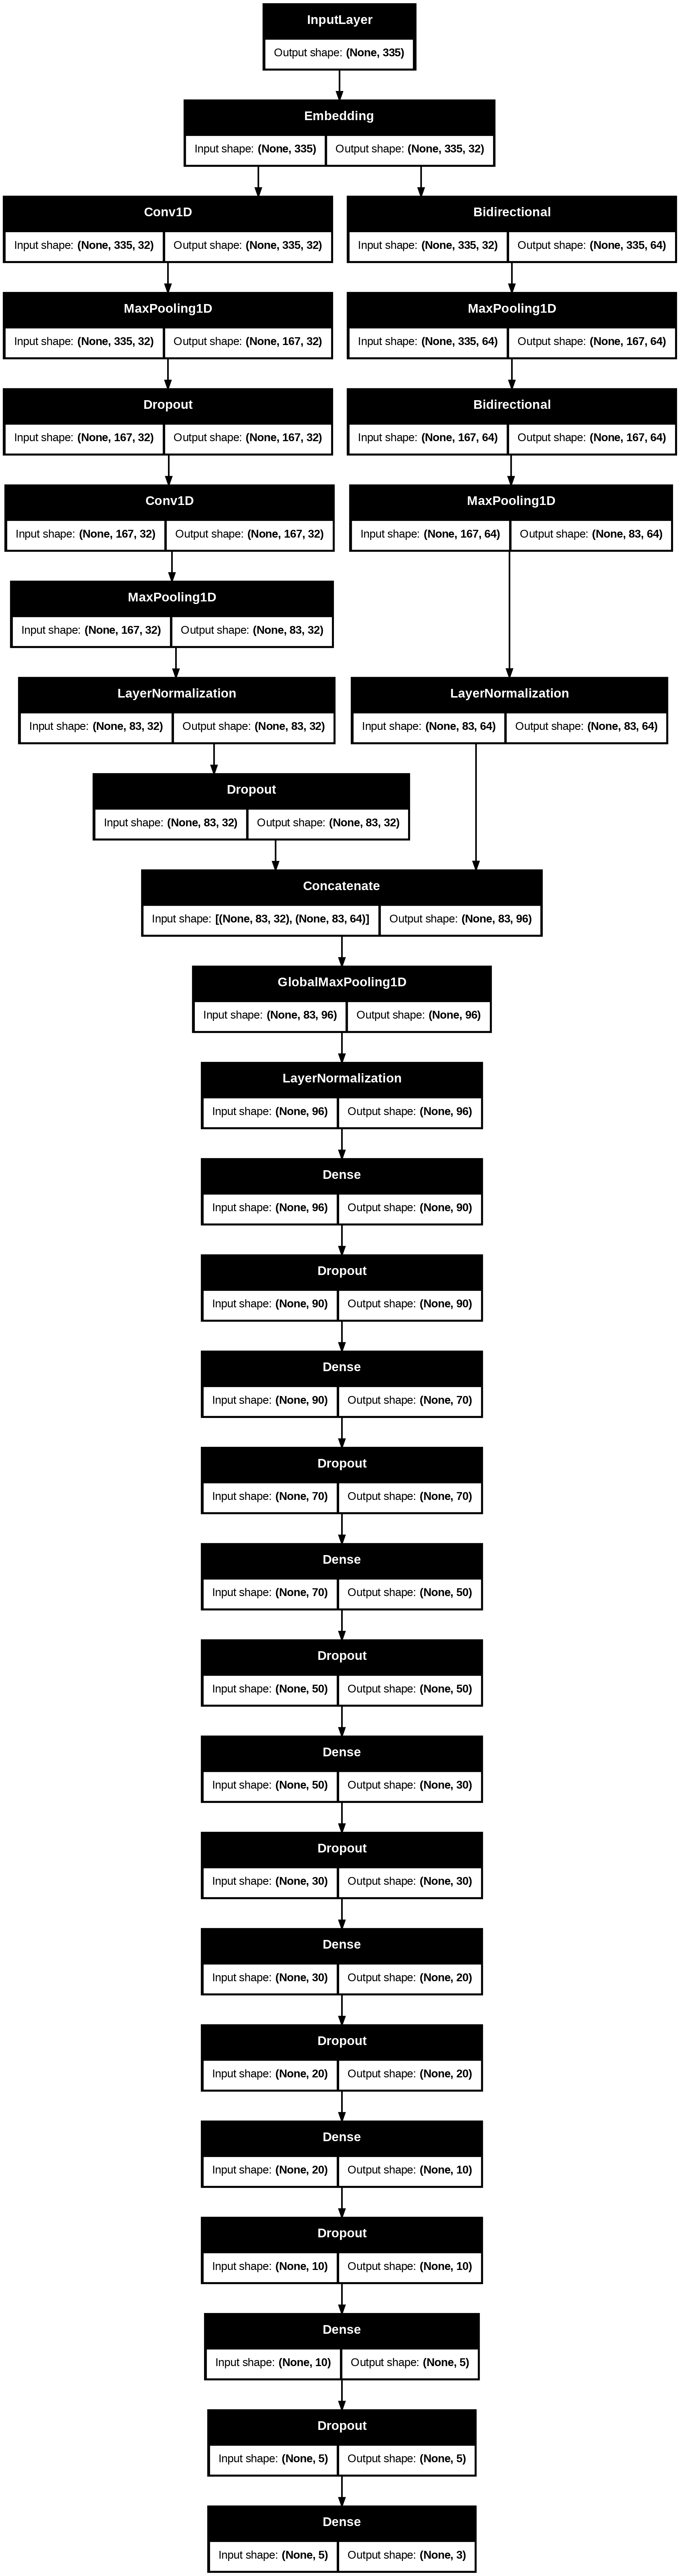

In [44]:
dot_img_file='model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

##Define model checkpoint and training

In [53]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    x=x_train, y=y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[callback_model, early_stopping]
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9670 - loss: 0.1213 - val_accuracy: 0.6713 - val_loss: 1.2489
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9717 - loss: 0.1052 - val_accuracy: 0.6740 - val_loss: 1.3939
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9769 - loss: 0.0854 - val_accuracy: 0.6722 - val_loss: 1.4227
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9792 - loss: 0.0823 - val_accuracy: 0.6696 - val_loss: 1.5292
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9832 - loss: 0.0661 - val_accuracy: 0.6862 - val_loss: 1.5200
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9868 - loss: 0.0564 - val_accuracy: 0.6862 - val_loss: 1.7487


In [54]:
model.load_weights('model_cnn_bilstm.keras')
model.evaluate(x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.6953 - loss: 1.4742


[1.4589478969573975, 0.6965065598487854]

##Inference Model with input test

In [55]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed: ", input_text_pre_accent)
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    # Changed maxlen to 335 to match the training data shape
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=335)
    return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  # label_dict = defaultdict(lambda: -2)  # Gán -2 cho các khóa không tồn tại
  # label_dict['tiêu cực'] = -1
  # label_dict['tích cực'] = 1
  # label_dict['trung lập'] = 0
  label_dict = {'tiêu cực':0, 'trung lập':1, 'tích cực':2}
  label = list(label_dict.keys())
  return label[int(result)], conf

def prediction(raw_input,tokenizer,model):
  input_model = preprocess_raw_input(raw_input,tokenizer_data)
  result, conf = inference_model(input_model, model)
  return result, conf

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.keras')
with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

print(prediction("sữa chua ngon lắm",my_tokenizer,my_model))

Text preprocessed:  sữa_chua ngon lắm
('tích cực', 0.9894437789916992)


In [56]:
while(True):
  text = input()
  if text == "end":
    break
  else:
    # Convert the prediction result to a string using str()
    print(str(prediction(text,my_tokenizer,my_model)[0])+"\n")

Đến đoạn này chả nhẽ lại ko bắn tiền cứu bạn
Text preprocessed:  đến đoạn này chả nhẽ lại ko bắn tiền cứu bạn
tiêu cực

Đấy nãy lại vừa nhắn tin hỏi kết con gì
Text preprocessed:  đấy nãy lại vừa nhắn_tin hỏi kết con gì
trung lập

"Mình biết là Má mình thương mình quá nên khi mình ko nghe lời hoặc làm Má thất vọng thì Má mình sẽ trút ra... con người, đâu ai hoàn hảo"
Text preprocessed:  mình biết là má mình thương mình quá nên khi mình ko nghe lời hoặc làm má thất_vọng thì má mình sẽ trút ra con_người đâu ai hoàn_hảo
tiêu cực

Đó là lần đầu tiên và cũng là lần cuối cùng đi chơi
Text preprocessed:  đó là lần đầu_tiên và cũng là lần cuối_cùng đi chơi
tiêu cực

"Chắc ko phải đâu thím, lúc ko nhậu thì vẫn làm việc chơi với mình rất vui vẻ, ông đẹp trai với may áo quần đẹp lắm, có tay nghề, nhiều người tới xin học nghề mà"
Text preprocessed:  chắc ko phải đâu thím lúc ko nhậu thì vẫn làm_việc chơi với mình rất vui_vẻ ông đẹp_trai với may áo_quần đẹp lắm có tay_nghề nhiều người tới xin học n

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-78a37acc6a4e>", line 2, in <cell line: 1>
    text = input()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 851, in raw_input
    return self._input_request(str(prompt),
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 895, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, 

TypeError: object of type 'NoneType' has no len()